Importing the packages needed for the experiment

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Importing the dataset and melting it.

The dataset actually contains 72 product x 36 rows of data. Making this as a dataset with Product and month and bringing all the sales value into a single column using pandas melt fuction

In [72]:
data = pd.read_excel("D:/Hackathons/Philips/Data/dataset.xlsx")
melt = data.melt(id_vars='Time series ID', var_name='Month', value_name='Sales')
melt = melt.sort_values(['Month', 'Time series ID'])
melt['Month']=melt['Month'].astype(str)
melt.head()

,Time series ID,Month,Sales
0,1,2016-01-01,5542.672
1,2,2016-01-01,3861.612
2,3,2016-01-01,1600.667
3,4,2016-01-01,316.565
4,5,2016-01-01,748.018


For ease of computation, renaming the month names to 1, 2, ... n

In [73]:
i = 1

for m in melt["Month"].unique():
    melt["Month"]= melt["Month"].replace(m, i)
    i = i + 1
    
melt["Month"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=int64)

In [74]:
melt=melt.rename(columns={"Time series ID": "Product_Code"})
melt4=melt.copy()

Visualizing few of the timeseries:

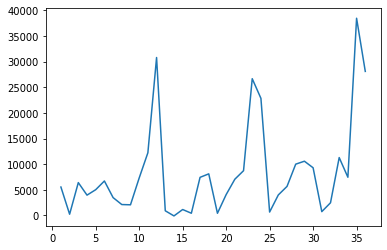

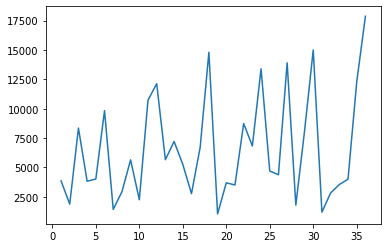

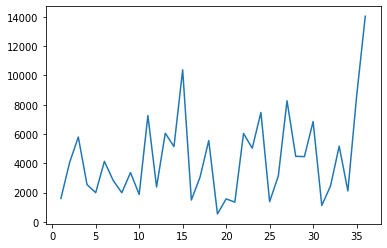

In [75]:
for i in range(1, 4):
    plt.plot(melt[melt["Product_Code"] == i]["Month"], melt[melt["Product_Code"] == i]["Sales"])
    plt.show()

Creating the following features below:

	• Product sales in the last three months
	• Product sales in last quarter
	• Product sales in last half-year
	• Product sales in the same period last year
	• Moving average for three months
	• Moving average for 6 months
	• One hot encoded product variables
	• One hot encoded month variables

In [76]:
def feature_engineering(df):
    df['Month-1'] = df.groupby(['Product_Code'])['Sales'].shift(1)
    df['Month-2'] = df.groupby(['Product_Code'])['Sales'].shift(2)
    df['Month-3'] = df.groupby(['Product_Code'])['Sales'].shift(3)
    df['Quarter'] = df.groupby(['Product_Code'])['Sales'].shift(4)
    df['Half_year'] = df.groupby(['Product_Code'])['Sales'].shift(6)
    df['Yearly'] = df.groupby(['Product_Code'])['Sales'].shift(12)
    df["MA3m"] = df.groupby('Product_Code')['Sales'].transform(lambda x: x.rolling(3, 1).mean())
    df["MA6m"] = df.groupby('Product_Code')['Sales'].transform(lambda x: x.rolling(6, 1).mean())
    return df

melt4 = feature_engineering(df = melt4)

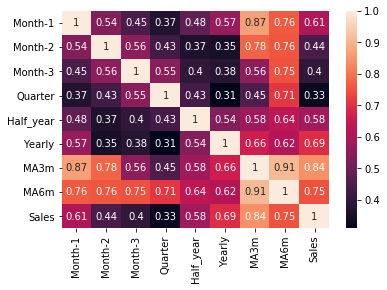

In [77]:
corr = train[['Month-1', 'Month-2', 'Month-3', 'Quarter', 'Half_year', 'Yearly', 'MA3m', 'MA6m', "Sales"]].corr()
sns.heatmap(corr, annot=True)

Splitting into train and test

In [78]:
train = melt4.query('Month <= 36')
train = train.replace(0,np.nan)
train = train.dropna(thresh = 8)
train.fillna(0, inplace=True)

test = melt4.query('Month > 36')
test.fillna(0, inplace=True)
test.head()

,Product_Code,Month,Sales,Month-1,Month-2,Month-3,Quarter,Half_year,Yearly,MA3m,MA6m
2592,1,37,0.0,28099.730,38467.176,7454.773,11292.438,748.901,664.996,33283.4530,17557.4120
2593,2,37,0.0,17872.682,12271.278,4001.930,3547.050,1198.495,4698.357,15071.9800,8104.6956
2594,3,37,0.0,14047.207,8566.166,2113.834,5171.708,1123.666,1382.958,11306.6865,6469.5662
2595,4,37,0.0,13076.867,6102.696,3506.122,1679.942,701.774,1019.356,9589.7815,5083.0526
2596,5,37,0.0,3398.971,1802.555,854.541,892.302,519.621,1145.361,2600.7630,1481.1126


In [79]:
result = test[["Product_Code","Month"]]

In [80]:
result["Sales"] = train.Sales.mean()
target = 'Sales'
IDcol = ["Product_Code", "Month"]

In [81]:
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    #cv_score = cross_validate.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='mean_squared_error')
    #cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)
    return submission, alg

predictors :  ['Month-1', 'Month-2', 'Month-3', 'Quarter', 'Half_year', 'Yearly', 'MA3m', 'MA6m']

Model Report
RMSE : 2.393e-12


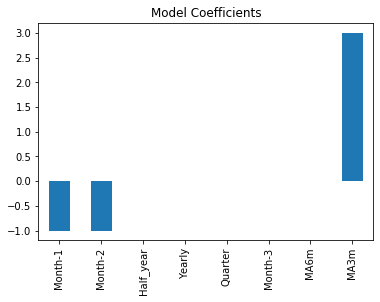

In [82]:
from sklearn.linear_model import LinearRegression
predictors = [x for x in train.columns if x not in [target]+IDcol]
print("predictors : ",predictors)
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'res2.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


Model Report
RMSE : 2.138


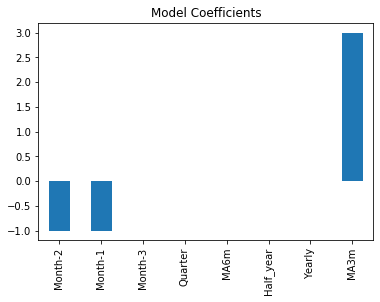

In [83]:
from sklearn.linear_model import ElasticNet
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = ElasticNet(alpha=0.01,l1_ratio=1,normalize=True)
test_file, elasti_net = modelfit(alg1, train, test, predictors, target, IDcol, 'res5.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

For making predictions on the 2019 data, it has to be done month on month, since only if we have Jan-2019's predictions with the rolling window. Hence once the prediction for Jan-2019 is available, it will then be used to forecast the value for Feb-2019 and so on.

In [84]:
for i in range(37, 49):
    print("Predicting for month: ", str(i))
    month_37 = test[test["Month"] == i]
    month_37["pred"] = alg1.predict(month_37[predictors])
    melt = melt.merge(month_37[["Product_Code", "Month", "pred"]], on = ["Product_Code", "Month"], how = 'left')
    melt["Sales"] = np.where(melt["pred"].isna(), melt["Sales"], melt["pred"])
    melt = melt.drop(columns = ["pred"])
    test = feature_engineering(df = melt)

Predicting for month:  37
Predicting for month:  38
Predicting for month:  39
Predicting for month:  40
Predicting for month:  41
Predicting for month:  42
Predicting for month:  43
Predicting for month:  44
Predicting for month:  45
Predicting for month:  46
Predicting for month:  47
Predicting for month:  48


In [85]:
test = test.query('Month > 36')[["Product_Code", "Month", "Sales"]]
output = test.pivot_table(index='Product_Code', columns='Month', values='Sales')